In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn
import joblib


# Load your data

In [26]:
df = pd.read_csv("africa_recession.csv")
print(df)

           pop        emp  emp_to_pop_ratio        hc           ccon  \
0    28.849621   6.914298          0.239667  1.547767   99010.171880   
1    45.728313  13.623806          0.297929  2.086037  316862.656300   
2    33.262043  13.323813          0.400571  1.498783   29762.876950   
3     8.025703   3.869000          0.482076  1.356151    6488.692871   
4     1.061468   0.243000          0.228928  1.676330    7620.187500   
..         ...        ...               ...       ...            ...   
481  12.208407   6.215000          0.509075  1.837961   21853.750000   
482  29.784193  15.389316          0.516694  1.467321   94663.101560   
483  55.797787  25.301973          0.453458  1.689919  102405.859400   
484  15.850567   5.277823          0.332974  1.579579   42087.269530   
485   7.797694   3.468000          0.444747  1.790903   11765.336910   

               cda            cn        ck      ctfp     cwtfp  ...  \
0    131991.375000  4.265433e+05  0.009374  0.648979  0.626111  

# Drop the classification target and highly correlated variable

In [3]:
X = df.drop(columns=['ctfp', 'growthbucket', 'cwtfp'])  # remove cwtfp to avoid multicollinearity
y = df['ctfp']
features=  X.columns.tolist()
print(features)

['pop', 'emp', 'emp_to_pop_ratio', 'hc', 'ccon', 'cda', 'cn', 'ck', 'rconna', 'rdana', 'rnna', 'rkna', 'rtfpna', 'rwtfpna', 'labsh', 'irr', 'delta', 'xr', 'pl_con', 'pl_da', 'pl_gdpo', 'csh_c', 'csh_i', 'csh_g', 'csh_x', 'csh_m', 'csh_r', 'pl_c', 'pl_i', 'pl_g', 'pl_x', 'pl_m', 'pl_n', 'total', 'excl_energy', 'energy', 'metals_minerals', 'forestry', 'agriculture', 'fish', 'total_change', 'excl_energy_change', 'energy_change', 'metals_minerals_change', 'forestry_change', 'agriculture_change', 'fish_change']


# Split into train/test sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train linear regression with gradient descent

In [6]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, eta0=0.01, learning_rate='invscaling', random_state=42)
train_losses = []
test_losses = []

# Manual training loop

In [7]:
for i in range(1, 201):
    sgd_reg.partial_fit(X_train_scaled, y_train)
    y_train_pred = sgd_reg.predict(X_train_scaled)
    y_test_pred = sgd_reg.predict(X_test_scaled)
    train_losses.append(mean_squared_error(y_train, y_train_pred))
    test_losses.append(mean_squared_error(y_test, y_test_pred))

# Evaluate model

In [8]:
final_pred = sgd_reg.predict(X_test_scaled)
mse = mean_squared_error(y_test, final_pred)
r2 = r2_score(y_test, final_pred)

print("Test MSE:", mse)
print("Test R² Score:", r2)

Test MSE: 0.011041247672797941
Test R² Score: 0.7326889162556345


# Save model and scaler

In [9]:
joblib.dump(sgd_reg, "linear_regression_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(features, "feature_names.pkl")

['feature_names.pkl']

# Plot loss curves

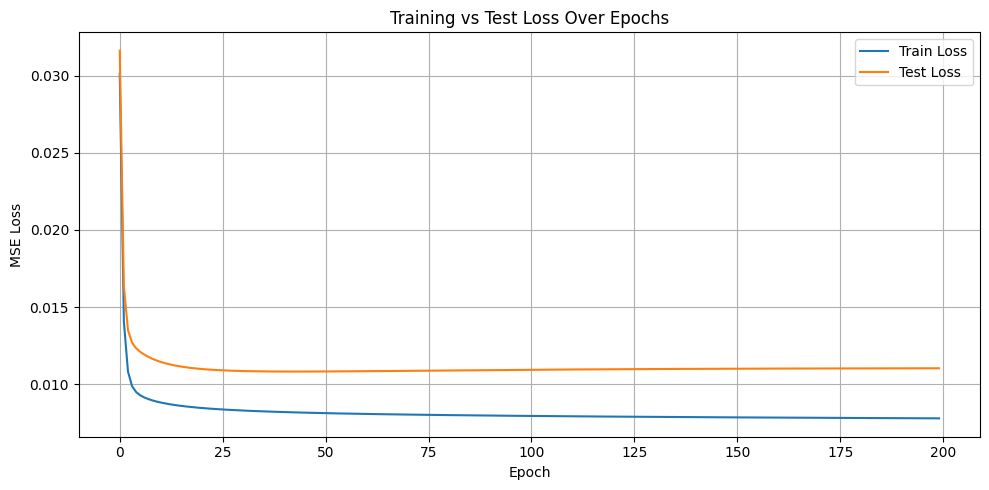

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Test Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Scatter plot of predicted vs actual

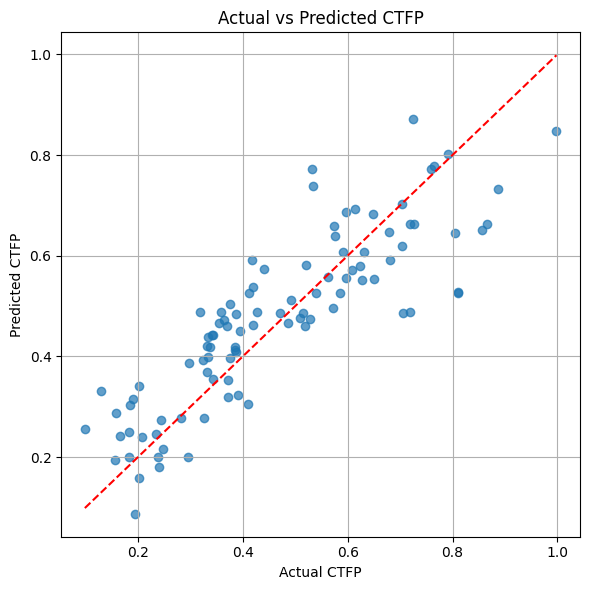

In [11]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, final_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual CTFP")
plt.ylabel("Predicted CTFP")
plt.title("Actual vs Predicted CTFP")
plt.grid(True)
plt.tight_layout()
plt.show()

# Reuse the scaled X_train and X_test

In [12]:
results = {}

# Linear Regression (already trained)

In [15]:
results["Linear Regression"] = {
    "model": sgd_reg,
    "y_pred": final_pred,
    "mse": mean_squared_error(y_test, final_pred),
    "r2": r2_score(y_test, final_pred)
}

# Decision Tree Regressor

In [17]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_scaled, y_train)
tree_pred = tree_reg.predict(X_test_scaled)
results["Decision Tree"] = {
    "model": tree_reg,
    "y_pred": tree_pred,
    "mse": mean_squared_error(y_test, tree_pred),
    "r2": r2_score(y_test, tree_pred)
}

# Random Forest Regressor

In [18]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train_scaled, y_train)
forest_pred = forest_reg.predict(X_test_scaled)
results["Random Forest"] = {
    "model": forest_reg,
    "y_pred": forest_pred,
    "mse": mean_squared_error(y_test, forest_pred),
    "r2": r2_score(y_test, forest_pred)
}


# Print comparison

In [19]:
print("Model Performance Comparison:\n")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  MSE: {metrics['mse']:.4f}")
    print(f"  R²: {metrics['r2']:.4f}")
    print()


Model Performance Comparison:

Linear Regression:
  MSE: 0.0110
  R²: 0.7327

Decision Tree:
  MSE: 0.0043
  R²: 0.8948

Random Forest:
  MSE: 0.0039
  R²: 0.9063



# Plot Actual vs Predicted for all models

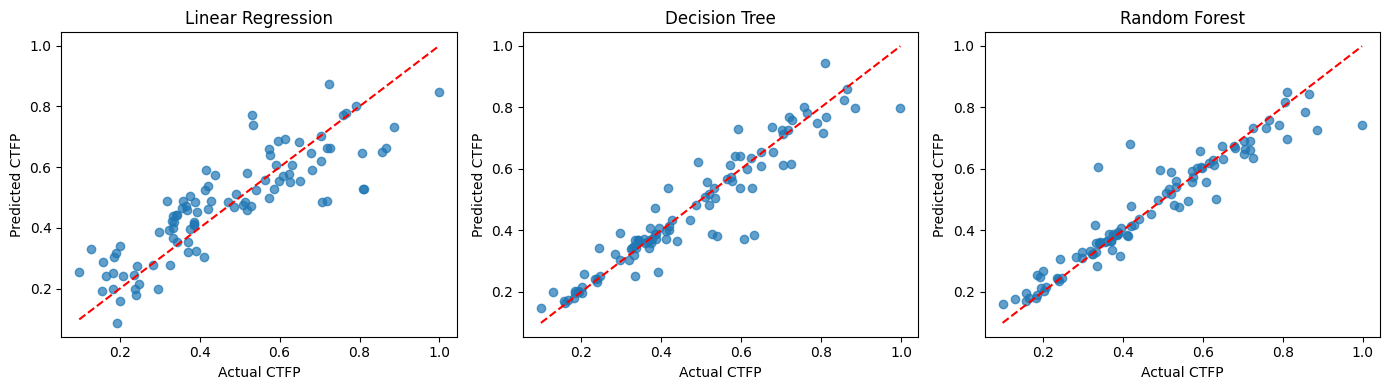

In [20]:
plt.figure(figsize=(14, 4))
for i, (model_name, metrics) in enumerate(results.items(), 1):
    plt.subplot(1, 3, i)
    plt.scatter(y_test, metrics['y_pred'], alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
    plt.xlabel("Actual CTFP")
    plt.ylabel("Predicted CTFP")
    plt.title(model_name)

plt.tight_layout()
plt.show()

# Save the Best Model

In [21]:
best_model_name = max(results, key=lambda k: results[k]['r2'])
joblib.dump(results[best_model_name]['model'], "best_model.pkl")
print(f"The Best model is: {best_model_name}")

The Best model is: Random Forest
